Лабораторная работа №1

In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import *
from pyspark.sql.types import *

MAX_MEMORY = '4G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY) \
        .set("spark.sql.optimizer.maxIterations", "500")
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'us-dealers-used-cleaned.csv'
df = spark.read.option("header", "true").csv(filename_data, mode="DROPMALFORMED")
df = df.withColumn("price",df.price.cast(IntegerType())) \
    .withColumn("miles",df.miles.cast(IntegerType())) \
    .withColumn("year",df.year.cast(IntegerType())) \
    .withColumn("engine_size",df.engine_size.cast(DoubleType())) \
    .drop("vin", "stock_no", "trim", "seller_name", "street", "city", "state", "zip","vehicle_type", "engine_block", "fuel_type","drivetrain")

print('Data overview')
df.printSchema()

total_cars_count = df.count()
total_cars_count

Data overview
root
 |-- id: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- miles: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- engine_size: double (nullable = true)



2296196

In [4]:
string_columns = ['id', 'make', 'model', 'body_type', 'transmission']
numeric_columns = ['price','miles', 'year', 'engine_size']

def view_missing_values_in_columns(string_columns, numeric_columns):
    missing_values = {}
    for index, column in enumerate(df.columns):
        if column in string_columns:
            missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        else: 
            missing_count = df.where(col(column).isin([0,None,np.nan]) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    
    return missing_values

pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,id,price,miles,year,make,model,body_type,transmission,engine_size
0,0,261778,40534,72,0,4015,13922,6758,51688


In [5]:
df = df.dropna(subset=['year']) \
    .dropna(subset=['model']) \
    .dropna(subset=['price']) \
    .dropna(subset=['engine_size']) \
    .dropna(subset=['transmission']) \
    .dropna(subset=['body_type'])

df = df.withColumn('price', 
                   when(col('price').isin([0,None,np.nan]) | col('price').isNull(),
                        None).otherwise(col('price')))

In [19]:
avg_value = df.select(mean('miles')).collect()[0]['avg(miles)']
df = df.withColumn('miles', 
                    when((col('miles').isin([0,None,np.nan])) | (col('miles').isNull()),
                        avg_value).otherwise(col('miles')))

In [20]:
pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,id,price,miles,year,make,model,body_type,transmission,engine_size
0,0,0,0,0,0,0,0,0,0


In [21]:
'Data frame describe (numeric columns only):'
df.select(df.price, df.miles, df.year, df.engine_size).describe().toPandas()

'Data frame describe (numeric columns only):'

,summary,price,miles,year,engine_size
0,count,2540175,2540175,2540175,2540175
1,mean,26658.521094019114,51547.75276424905,2016.6747271349416,2.8245025244378104
2,stddev,17702.136430029186,42616.95567621496,3.3851618887635295,1.2548678443283363
3,min,750,1.0,1981,0.6
4,max,1495000,2258202.0,2022,30.0


In [22]:
for column in ['miles', 'price', 'engine_size']:

    # Q1 : First Quartile ., Q3 : Third Quartile
    Q1 = df.approxQuantile(column,[0.25],relativeError=0)
    Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
    # IQR : Inter Quantile Range
    # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
    # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
    IQR = Q3[0] - Q1[0]
        
    #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
    less_Q1 =  Q1[0] - 1.5*IQR
    more_Q3 =  Q3[0] + 1.5*IQR
           
    df = df.filter((df[column] < more_Q3) & (df[column] > less_Q1))    

df.select(df.price, df.miles, df.year, df.engine_size).describe().toPandas()

,summary,price,miles,year,engine_size
0,count,2296374,2296374,2296374,2296374
1,mean,24769.23554090057,47250.33521130201,2016.9272788317583,2.63973821338161
2,stddev,10951.265052535198,33616.578619032094,2.965507480394549,1.0459963521587712
3,min,888,1.0,1981,0.6
4,max,58610,146279.0,2022,5.7


In [23]:
car_count_by_make = df.select(df.make, df.id) \
    .groupBy(df.make) \
    .count() \
    .collect()

for make in car_count_by_make:
    if make.asDict()['count'] < 100:
        df = df.filter(df.make != brand.make)

In [24]:
df.repartition(1).write.option("header", "true").csv('us-dealers-used-cleaned.csv')

Отразим 10 самых популярных марок автомобилей 

Top 10 cars makes:


/tmp/ipykernel_2212/1308851930.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label = axs[0].set_xticklabels(highest_cars_makes_df['make'],


,make,count,percentage
0,Ford,270217,11.768029
1,Toyota,225793,9.833350
2,Chevrolet,220923,9.621261
3,Honda,200272,8.721904
4,Nissan,168057,7.318931
5,Jeep,134546,5.859517
6,BMW,113956,4.962817
7,Hyundai,111459,4.854072
8,Kia,91495,3.984634
9,Mercedes-Benz,81942,3.568598


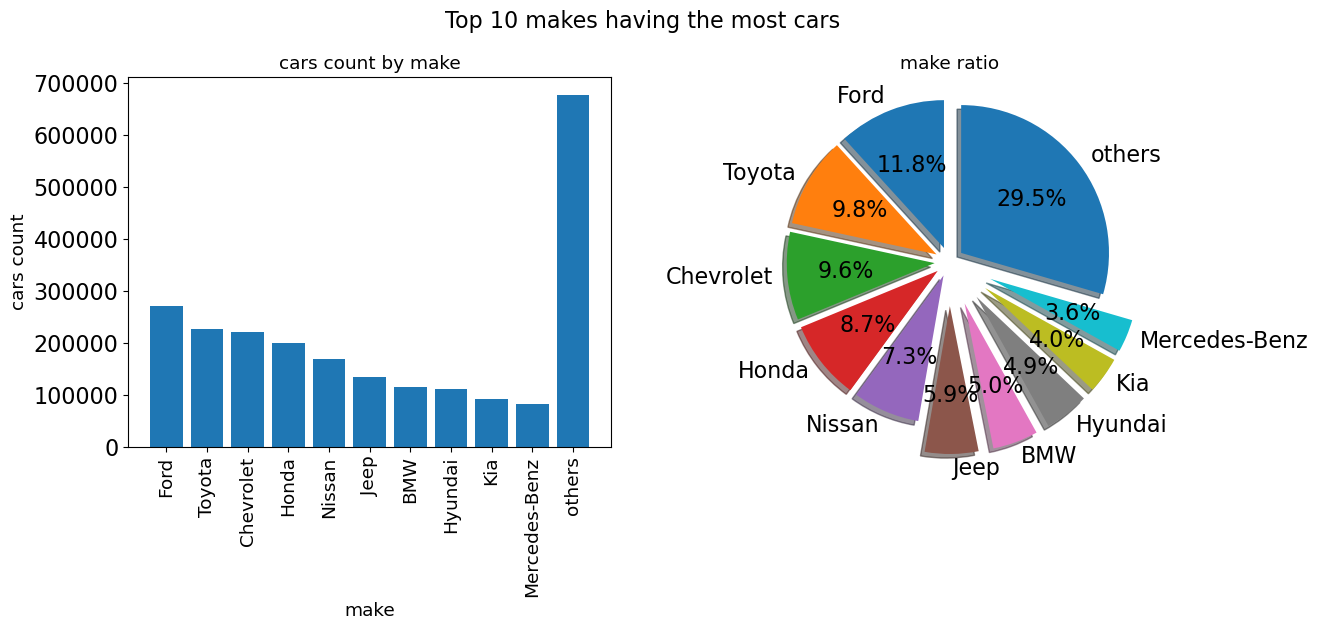

In [44]:
highest_cars_makes_df = df.select(df.make, df.id) \
    .groupBy(df.make) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(10) \
    .toPandas()


highest_cars_makes_df['percentage'] = highest_cars_makes_df['count'] \
    / total_cars_count * 100

others = {
    'make': 'others', 
    'count': total_cars_count - np.sum(highest_cars_makes_df['count']), 
    'percentage': 100 - np.sum(highest_cars_makes_df['percentage'])
}

highest_cars_makes_df = pd.concat([highest_cars_makes_df,pd.DataFrame.from_dict([others])])


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 =   axs[0].bar(x=highest_cars_makes_df['make'], 
                     height=highest_cars_makes_df['count'])
title0 =  axs[0].set_title('cars count by make', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('make', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('cars count', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(highest_cars_makes_df['make'],
                                       rotation = 'vertical', fontsize='small')
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.3,0.3,0.3,0.3,0.3,0.1)
title1 = axs[1].set_title('make ratio', fontsize = 'small')
plot1 = axs[1].pie(
    x=highest_cars_makes_df['percentage'],
    labels=highest_cars_makes_df['make'], 
    autopct='%1.1f%%', 
    shadow=True, 
    explode=explode, 
    startangle=90, 
    radius=1
)

print('Top 10 cars makes:')
highest_cars_makes_df


text = fig.text(0.5, 1.02, 'Top 10 makes having the most cars', ha='center', va='top', transform=fig.transFigure)

График распределения брендов на основе трансмиссии

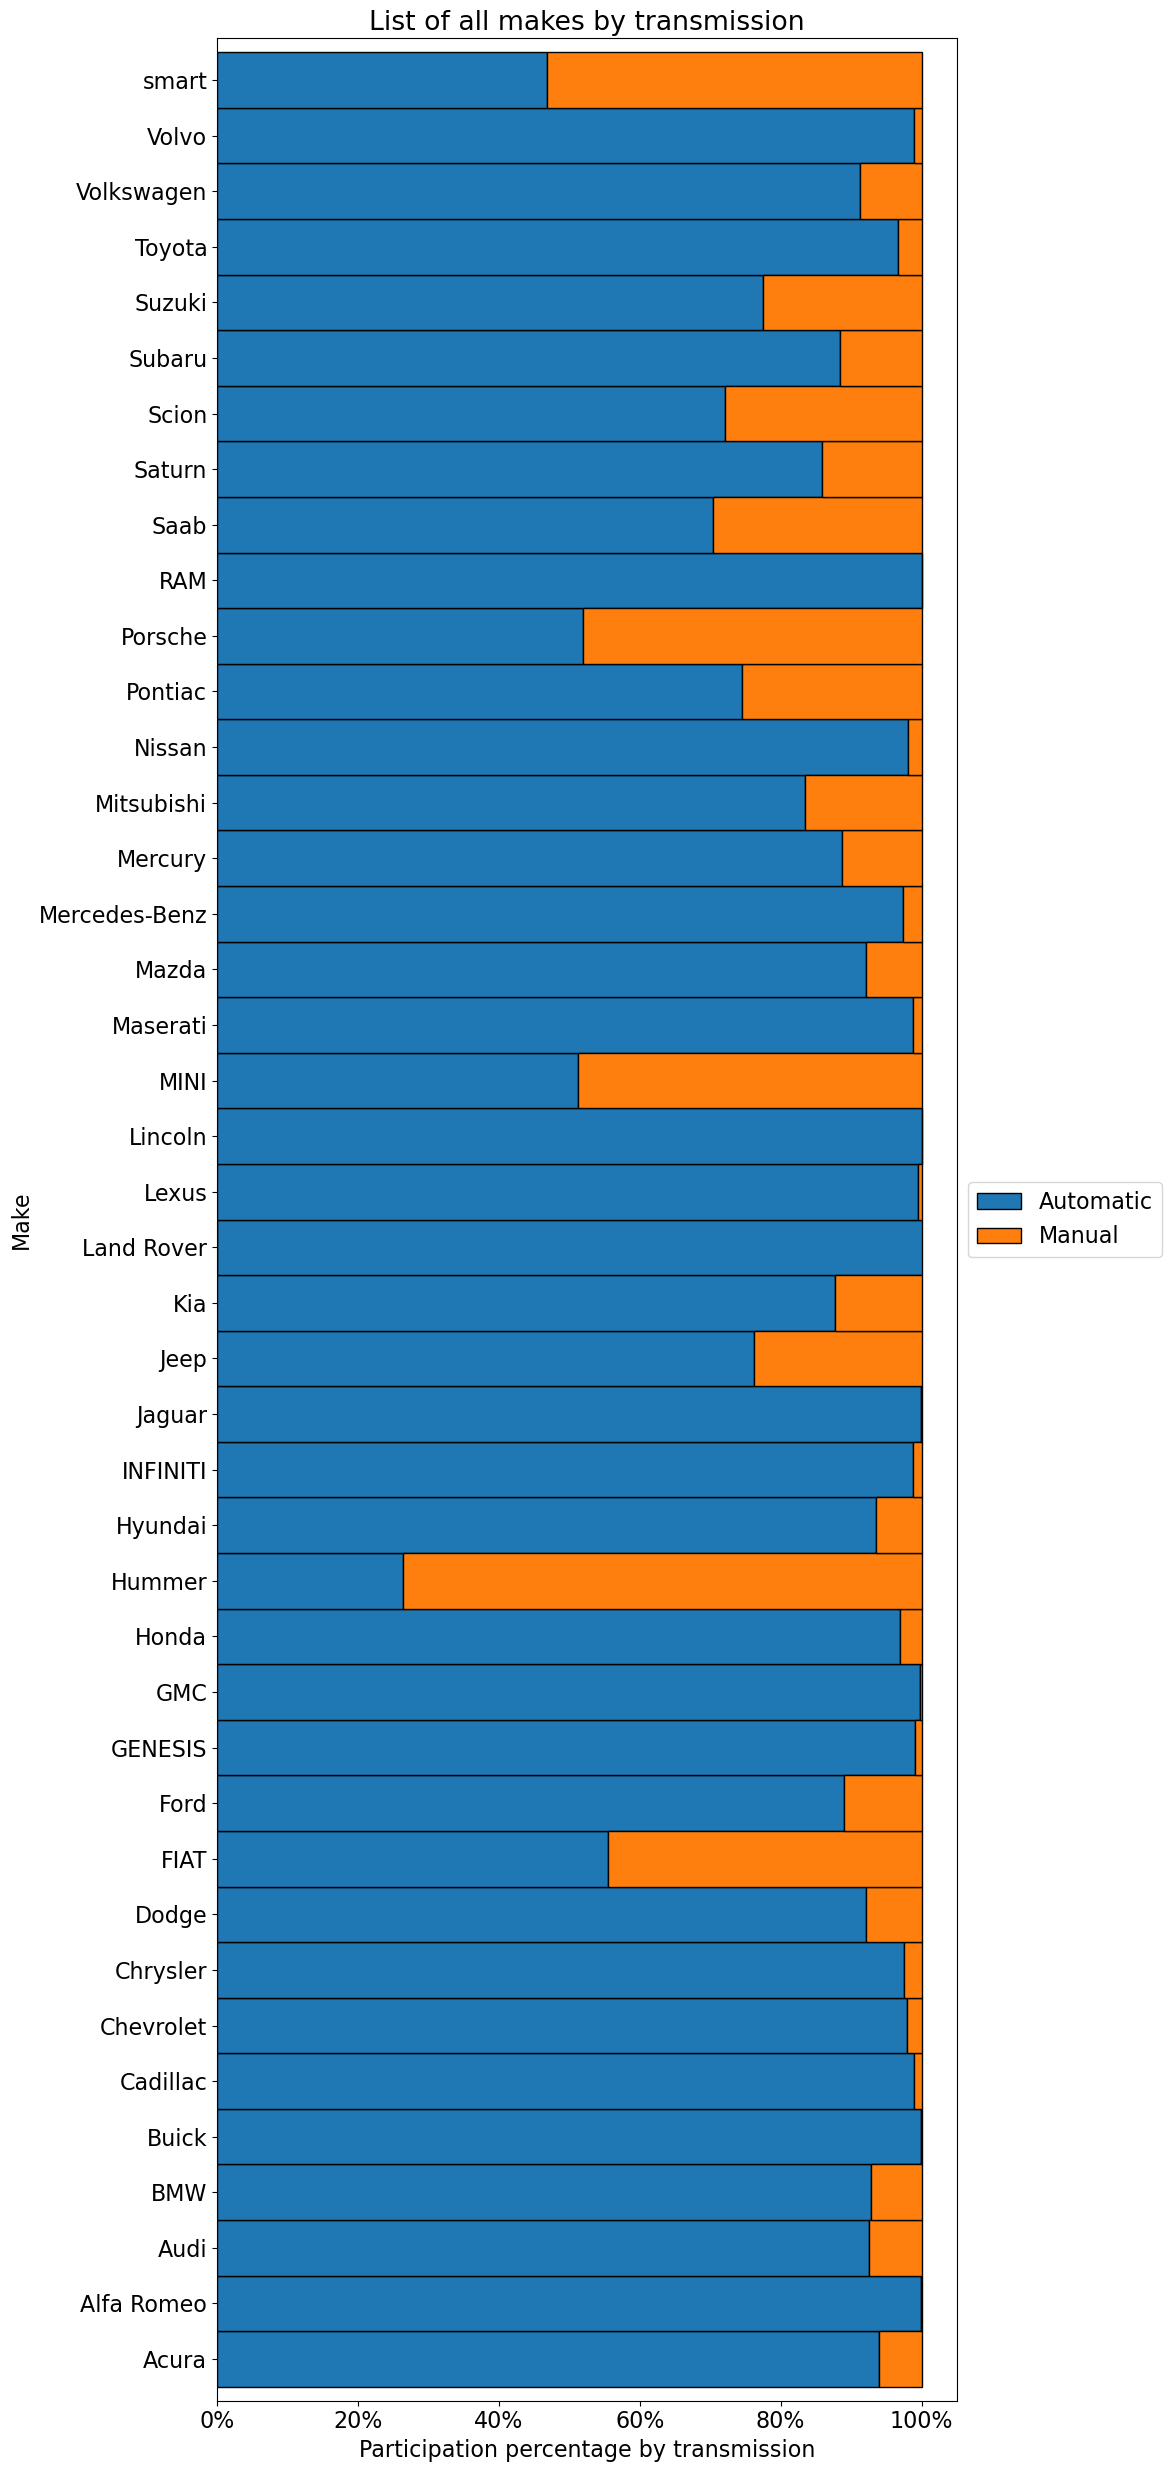

In [34]:
makes_by_transmission_df = df.groupBy(df.make, df.transmission).count().toPandas()

transmissions = makes_by_transmission_df['transmission'].unique()

fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = makes_by_transmission_df.groupby(['make', 'transmission'],group_keys=True).agg(np.mean) \
    .groupby(level=0,group_keys=False) \
    .apply(
        lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', 
                                                    stacked=True, 
                                                    width=1,
                                                    edgecolor='black', 
                                                    ax=ax, 
                                                    title='List of all makes by transmission')
ylabel = plt.ylabel('Make');
xlabel = plt.xlabel('Participation percentage by transmission');
legend = plt.legend(
    sorted(transmissions), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()


Исследуем 10 самых популярных марок автомобилей на использование ручной или автоматической трансмиссии

In [37]:
makes_by_transmission_df = df.groupBy(df.make, df.transmission).count().toPandas().pivot_table(
    index="make", columns="transmission", values='count', fill_value=0) \
    .reset_index() \
    .rename_axis(None, axis=1) \
    
makes_by_transmission_df['total'] = 0
for transmission in transmissions:
    makes_by_transmission_df['total'] += makes_by_transmission_df[transmission]
    
makes_by_transmission_df['percentage'] = makes_by_transmission_df['total'] / np.sum(makes_by_transmission_df['total']) * 100

for transmission in transmissions:
    makes_by_transmission_df['percentage ' + transmission] = \
        (makes_by_transmission_df[transmission] / makes_by_transmission_df['total']) * 100

top_makes_by_transmission_df = makes_by_transmission_df.sort_values(
    by='percentage', ascending=False
).head(10)

others = {'make' : 'others'}
for column in [*['total', 'percentage'], *transmissions,]:
    value = np.sum(makes_by_transmission_df[column]) - np.sum(top_makes_by_transmission_df[column])
    others.update({column: value})

for transmission in transmissions:
    value = (others[transmission] / others['total']) * 100
    others.update({'percentage ' + transmission: value})
    
top_brends_by_transmission_df = pd.concat([top_makes_by_transmission_df,pd.DataFrame.from_dict([others])]) \
                                .reset_index(drop=True)

top_brends_by_transmission_df

,make,Automatic,Manual,total,percentage,percentage Automatic,percentage Manual
0,Ford,240616,29601,270217,11.768029,89.045471,10.954529
1,Toyota,218380,7413,225793,9.833350,96.716904,3.283096
2,Chevrolet,216238,4685,220923,9.621261,97.879352,2.120648
3,Honda,194045,6227,200272,8.721904,96.890729,3.109271
4,Nissan,164779,3278,168057,7.318931,98.049471,1.950529
5,Jeep,102586,31960,134546,5.859517,76.246042,23.753958
6,BMW,105836,8120,113956,4.962817,92.874443,7.125557
7,Hyundai,104311,7148,111459,4.854072,93.586879,6.413121
8,Kia,80201,11294,91495,3.984634,87.656156,12.343844
9,Mercedes-Benz,79823,2119,81942,3.568598,97.414025,2.585975


Найдем 10 марок, с наибольшим процентом автомобилей, имеющих ручную трансмиссию 

In [40]:
top_makes_by_manual_transmission_df = makes_by_transmission_df.sort_values(
    by='percentage Manual', ascending=False
).head(10).reset_index(drop=True)

top_makes_by_manual_transmission_df

,make,Automatic,Manual,total,percentage,percentage Automatic,percentage Manual
0,Hummer,48,134,182,0.007926,26.373626,73.626374
1,smart,197,223,420,0.018291,46.904762,53.095238
2,MINI,8751,8340,17091,0.744318,51.202387,48.797613
3,Porsche,3556,3290,6846,0.298145,51.942740,48.057260
4,FIAT,1696,1364,3060,0.133264,55.424837,44.575163
5,Saab,178,75,253,0.011018,70.355731,29.644269
6,Scion,2065,797,2862,0.124641,72.152341,27.847659
7,Pontiac,970,332,1302,0.056702,74.500768,25.499232
8,Jeep,102586,31960,134546,5.859517,76.246042,23.753958
9,Suzuki,237,69,306,0.013326,77.450980,22.549020


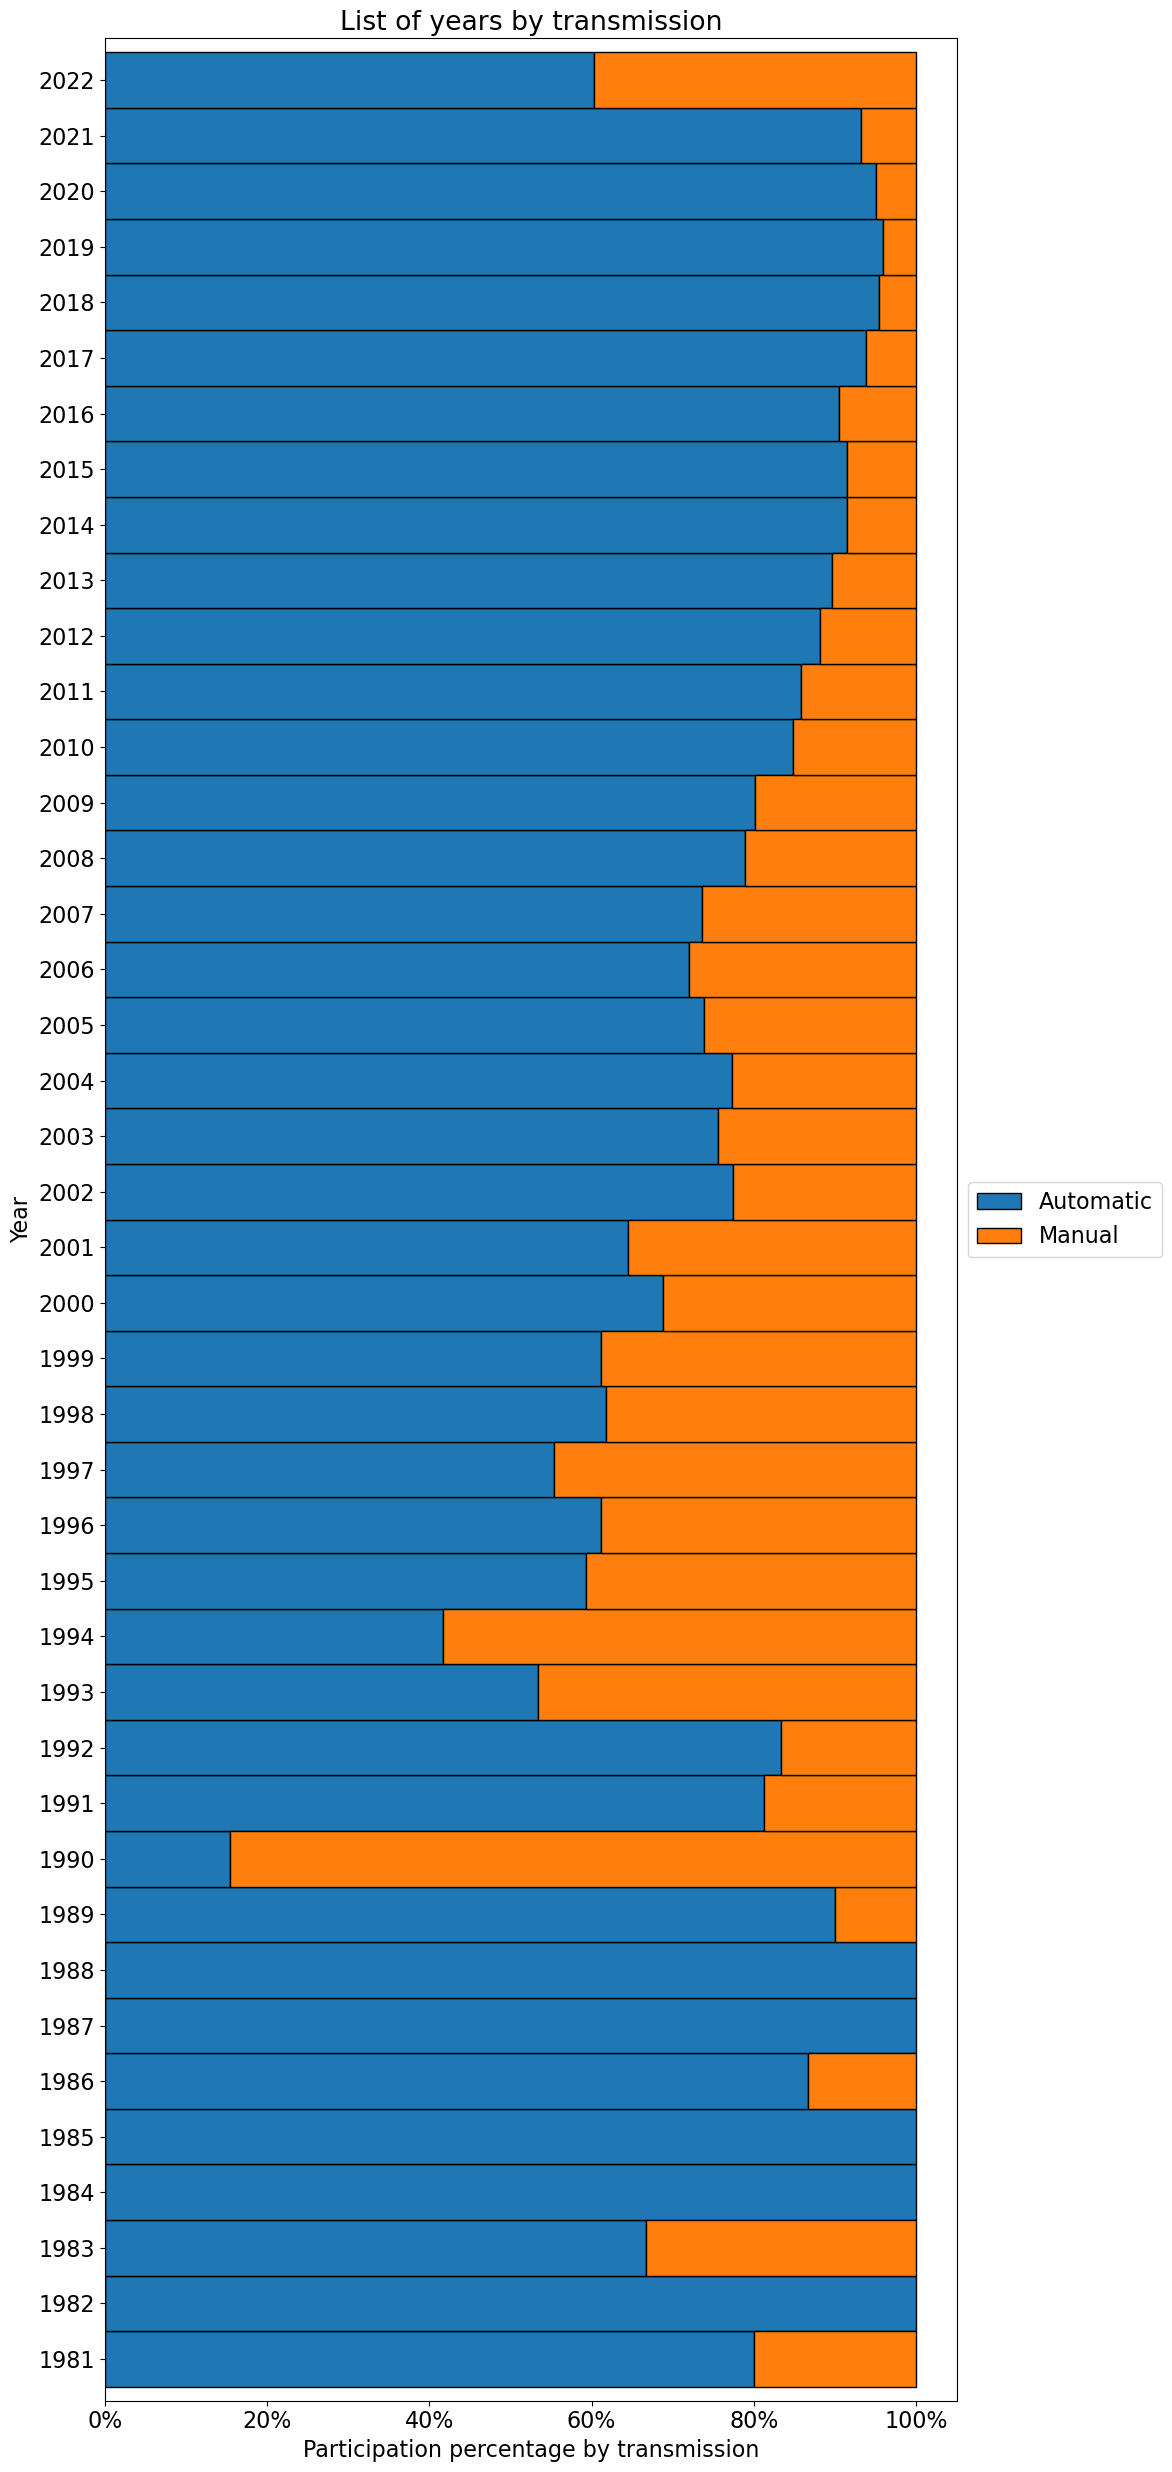

In [42]:
year_by_transmission_df = df.groupBy(df.year, df.transmission).count().toPandas()

fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = year_by_transmission_df.groupby(['year', 'transmission'],group_keys=True).agg(np.mean) \
    .groupby(level=0, group_keys=False) \
    .apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', 
                                                stacked=True, 
                                                width=1,
                                                edgecolor='black', 
                                                ax=ax, 
                                                title='List of years by transmission')
ylabel = plt.ylabel('Year');
xlabel = plt.xlabel('Participation percentage by transmission');
legend = plt.legend(
    sorted(transmissions), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()


Найдем средний объём двигателя у 10 самых популярных марок автомобилей 

In [47]:
highest_cars_makes_eng_size_mean = []
highest_cars_makes_eng_size_stddev = []
highest_cars_makes_eng_size_min = []
highest_cars_makes_eng_size_max = []

for make in highest_cars_makes_df['make']:
    if make != 'others': 
        describe_values = df.select(df.engine_size).filter(df.make == make).describe().toPandas()
    else:
        makes = highest_cars_makes_df['make'].tolist()
        describe_values = df.select(df.engine_size).filter(col('make').isin(makes) == False).describe().toPandas()
    highest_cars_makes_eng_size_mean.append(float(describe_values.loc[1]['engine_size']))
    highest_cars_makes_eng_size_stddev.append(float(describe_values.loc[2]['engine_size']))
    highest_cars_makes_eng_size_min.append(float(describe_values.loc[3]['engine_size']))
    highest_cars_makes_eng_size_max.append(float(describe_values.loc[4]['engine_size']))

highest_cars_makes_df['mean engine size'] = highest_cars_makes_eng_size_mean
highest_cars_makes_df['stddev engine size'] = highest_cars_makes_eng_size_stddev
highest_cars_makes_df['min engine size'] = highest_cars_makes_eng_size_min
highest_cars_makes_df['max engine size'] = highest_cars_makes_eng_size_max
    
highest_cars_makes_df

,make,count,percentage,mean engine size,stddev engine size,min engine size,max engine size
0,Ford,270217,11.768029,2.813960,1.191619,1.0,5.4
1,Toyota,225793,9.833350,2.768837,0.921712,1.5,5.7
2,Chevrolet,220923,9.621261,2.878793,1.549534,1.2,5.7
3,Honda,200272,8.721904,2.062930,0.640455,1.0,3.5
4,Nissan,168057,7.318931,2.643164,0.903362,1.6,5.6
5,Jeep,134546,5.859517,2.871767,0.713042,1.3,5.7
6,BMW,113956,4.962817,2.422353,0.677899,0.6,5.0
7,Hyundai,111459,4.854072,2.145348,0.430480,1.4,5.0
8,Kia,91495,3.984634,2.229312,0.460301,1.5,5.0
9,Mercedes-Benz,81942,3.568598,2.508399,0.878193,1.8,5.6


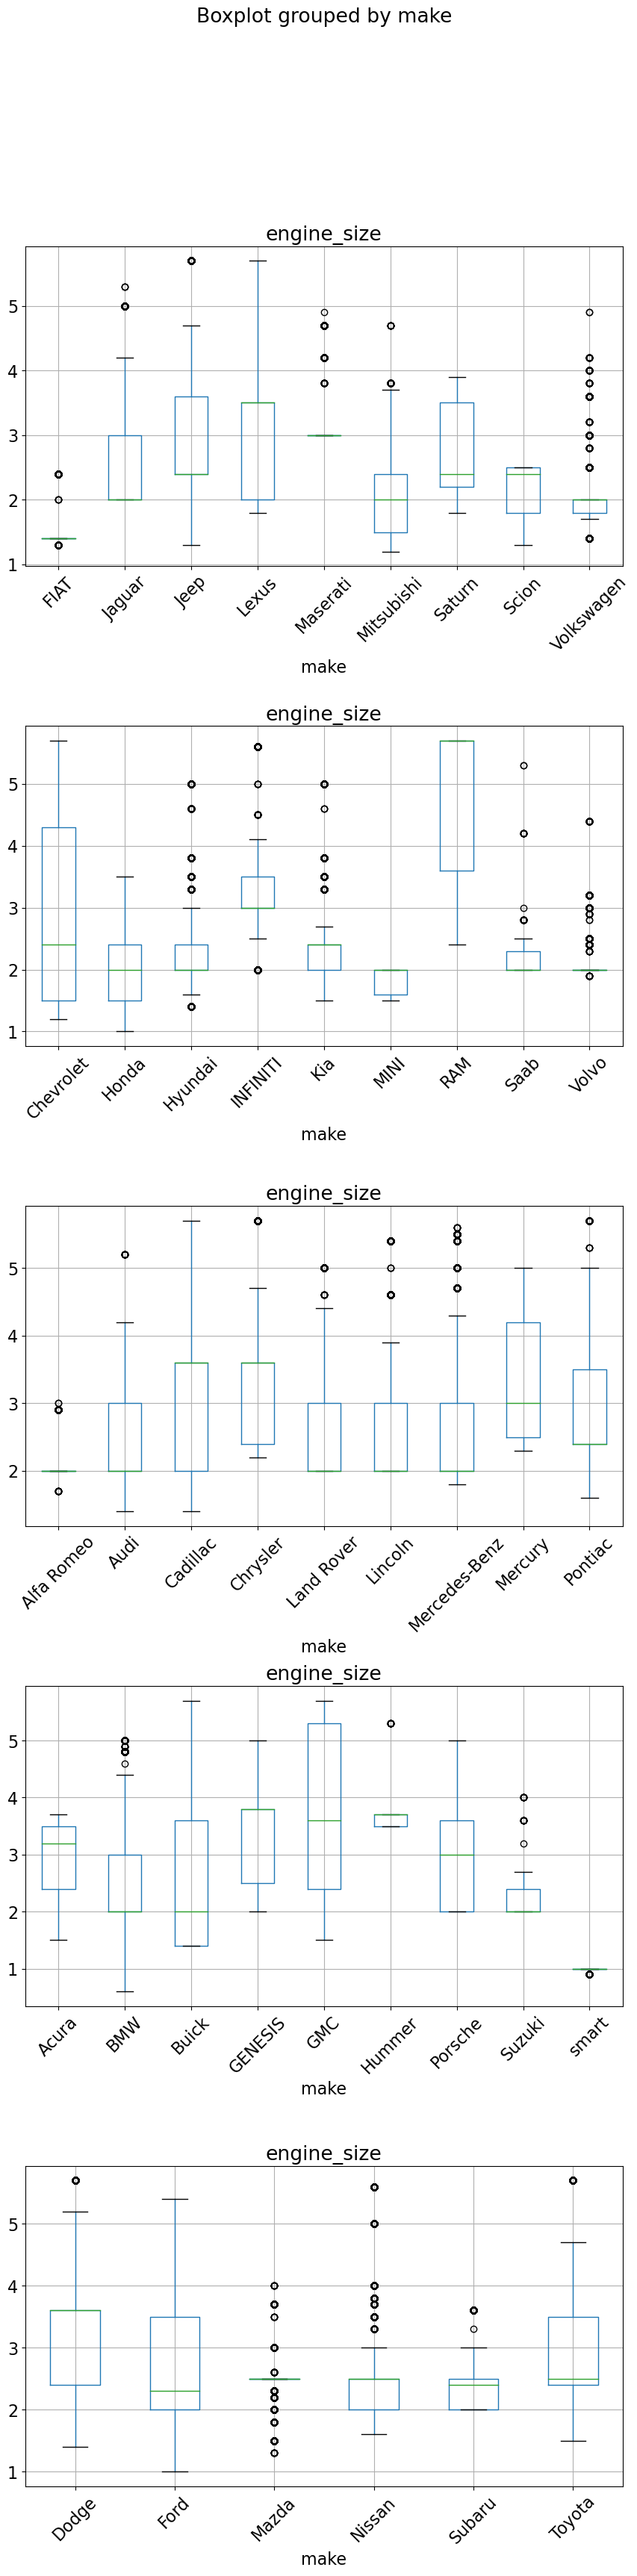

In [52]:
all_makes = df.select(df.make).distinct().toPandas()
boxplot_cols = 9
boxplot_rows = math.ceil(all_makes.count()/boxplot_cols)

fig, axes = plt.subplots(boxplot_rows, figsize=(10, 40))

for row in range(0,boxplot_rows):
    current_makes = all_makes.iloc[row*boxplot_cols:row*boxplot_cols+boxplot_cols]['make'].values.tolist()
    #df.select(df.make, df.engine_size).filter(col('make').isin(current_brands)) \
    #    .toPandas().boxplot(column='engine_size', by='make', ax=axes[row])
    engine_size_df = df.select(df.make, df.engine_size).filter(col('make').isin(current_makes)).toPandas()
    engine_size_df['engine_size'] = engine_size_df['engine_size'].astype('float')
    engine_size_df.boxplot(column='engine_size', by='make', ax=axes[row], rot=45)
    
plt.subplots_adjust(hspace=0.5)
plt.show();


Отобразим общее распределение цен на автомобили 

array([[<AxesSubplot: title={'center': 'price'}>]], dtype=object)

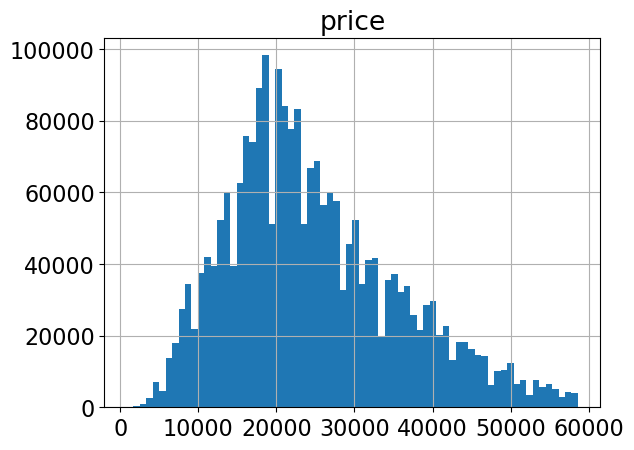

In [55]:
df.select(df.price, df.id).toPandas().hist(column='price',bins=70)

Рассмотрим среднюю цену на автомобили за последние 5 лет

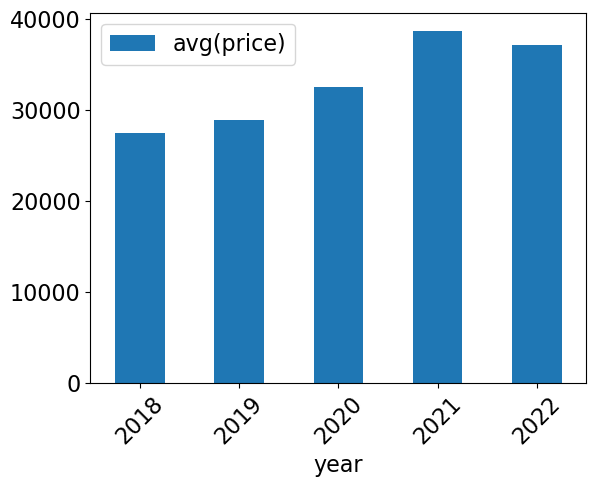

In [67]:
last_years = [2022,2021,2020,2019,2018]

_ = df.select(df.year, df.price) \
    .filter(df.year.isin(last_years)) \
    .groupBy(df.year) \
    .avg('price') \
    .toPandas() \
    .sort_values(by='year') \
    .plot.bar(column="avg(price)", x='year', rot=45)

Найдем 5 самых продоваемых автомобилей за последние 5 лет 

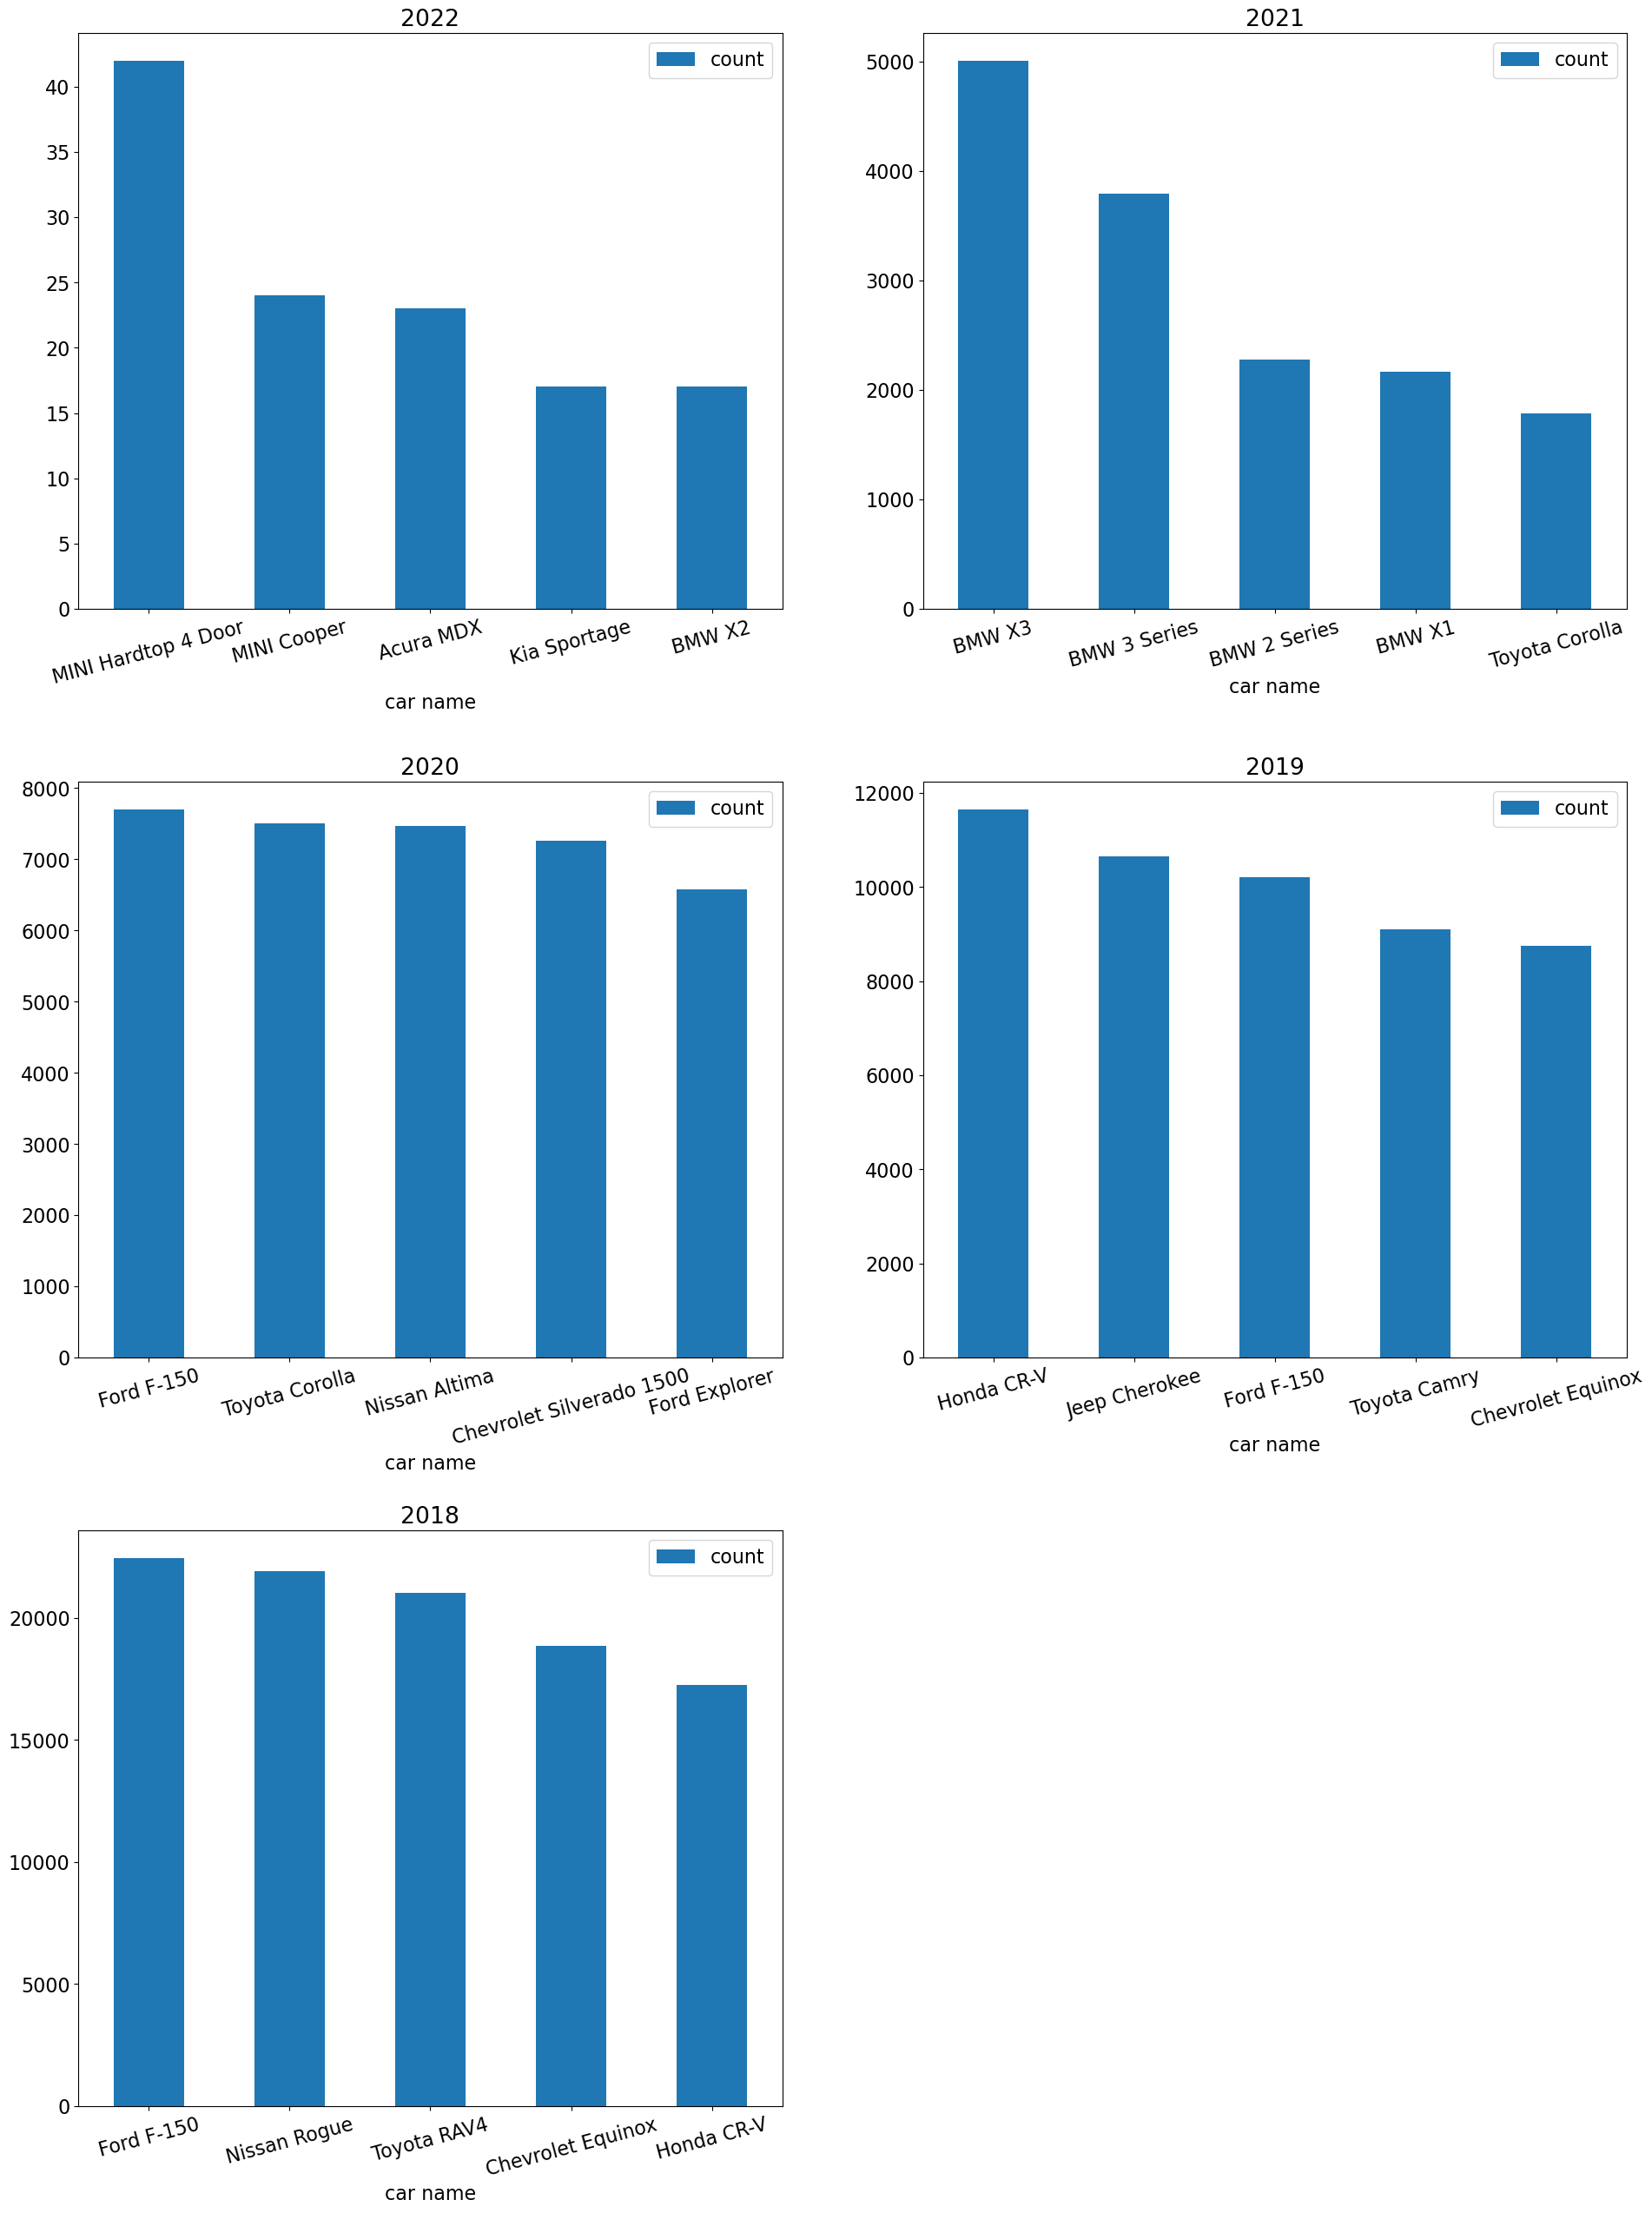

In [70]:
@udf(returnType=StringType()) 
def get_full_car_name_udf(car_make, car_model):
    return car_make + ' '+ car_model

plot_size_x, plot_size_y = 10, 10
figsize_x, figsize_y = plot_size_x * 2 + 3, plot_size_y * 3 + 1
figsize=(figsize_x, figsize_y)
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(figsize_x, figsize_y))


for i in range(len(last_years)):
    row_index, col_index = divmod(i, 2)
    top_sold_by_year = df.select(get_full_car_name_udf(df.make, df.model).alias('car name'), df.year) \
        .filter(df.year == last_years[i]) \
        .groupBy('car name') \
        .count() \
        .toPandas() \
        .sort_values(by='count', ascending=False) \
        .head(5)
    _ = top_sold_by_year.plot.bar(column="count", x='car name', rot=15, ax = ax[row_index, col_index])
    _ = ax[row_index, col_index].set_title(last_years[i])

ax[2, 1].set_visible(False)
plt.subplots_adjust(hspace=0.3)

Отобрзим средную цену автомобиля для каждого производителя

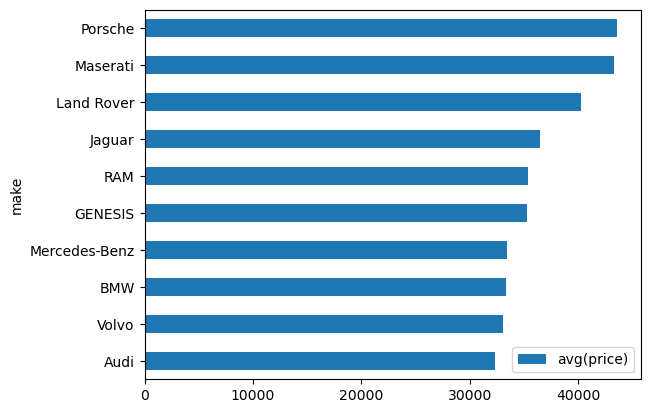

In [13]:
_ = df.select(df.make, df.price) \
    .groupBy(df.make) \
    .avg('price') \
    .orderBy('avg(price)',ascending=True) \
    .toPandas() \
    .tail(10) \
    .plot.barh(column="avg(price)", x='make')

Найдем 10 самых популярных моделей

In [74]:
all_makes = df.select(df.make) \
    .distinct() \
    .rdd.flatMap(lambda x: x).collect()

most_popular_models = []

for make in all_makes:
    most_popular_model = df.select(df.model) \
        .filter(df.make==make) \
        .groupBy(df.model) \
        .count() \
        .orderBy('count', ascending=False) \
        .head(1)[0]
    
    most_popular_models.append(
        {
            'make': make,
            'model': most_popular_model.model,
            'count': most_popular_model['count']
        }
    )
    
top_most_popular_models_df = pd.DataFrame(most_popular_models) \
    .sort_values(by='count', ascending=False) \
    .head(10) \
    .reset_index(drop=True)
top_most_popular_models_df

,make,model,count
0,Ford,F-150,67832
1,Honda,CR-V,60544
2,Toyota,RAV4,50613
3,Chevrolet,Equinox,50083
4,Nissan,Rogue,48991
5,RAM,Ram 1500 Pickup,30830
6,Jeep,Cherokee,29170
7,BMW,3 Series,26673
8,Hyundai,Sonata,24686
9,Volkswagen,Jetta,21344


Визуализируем распределение цен на 5 самых популярных машин, ограничив выборку относительно новыми машинами (пробег меньше 20000 миль)

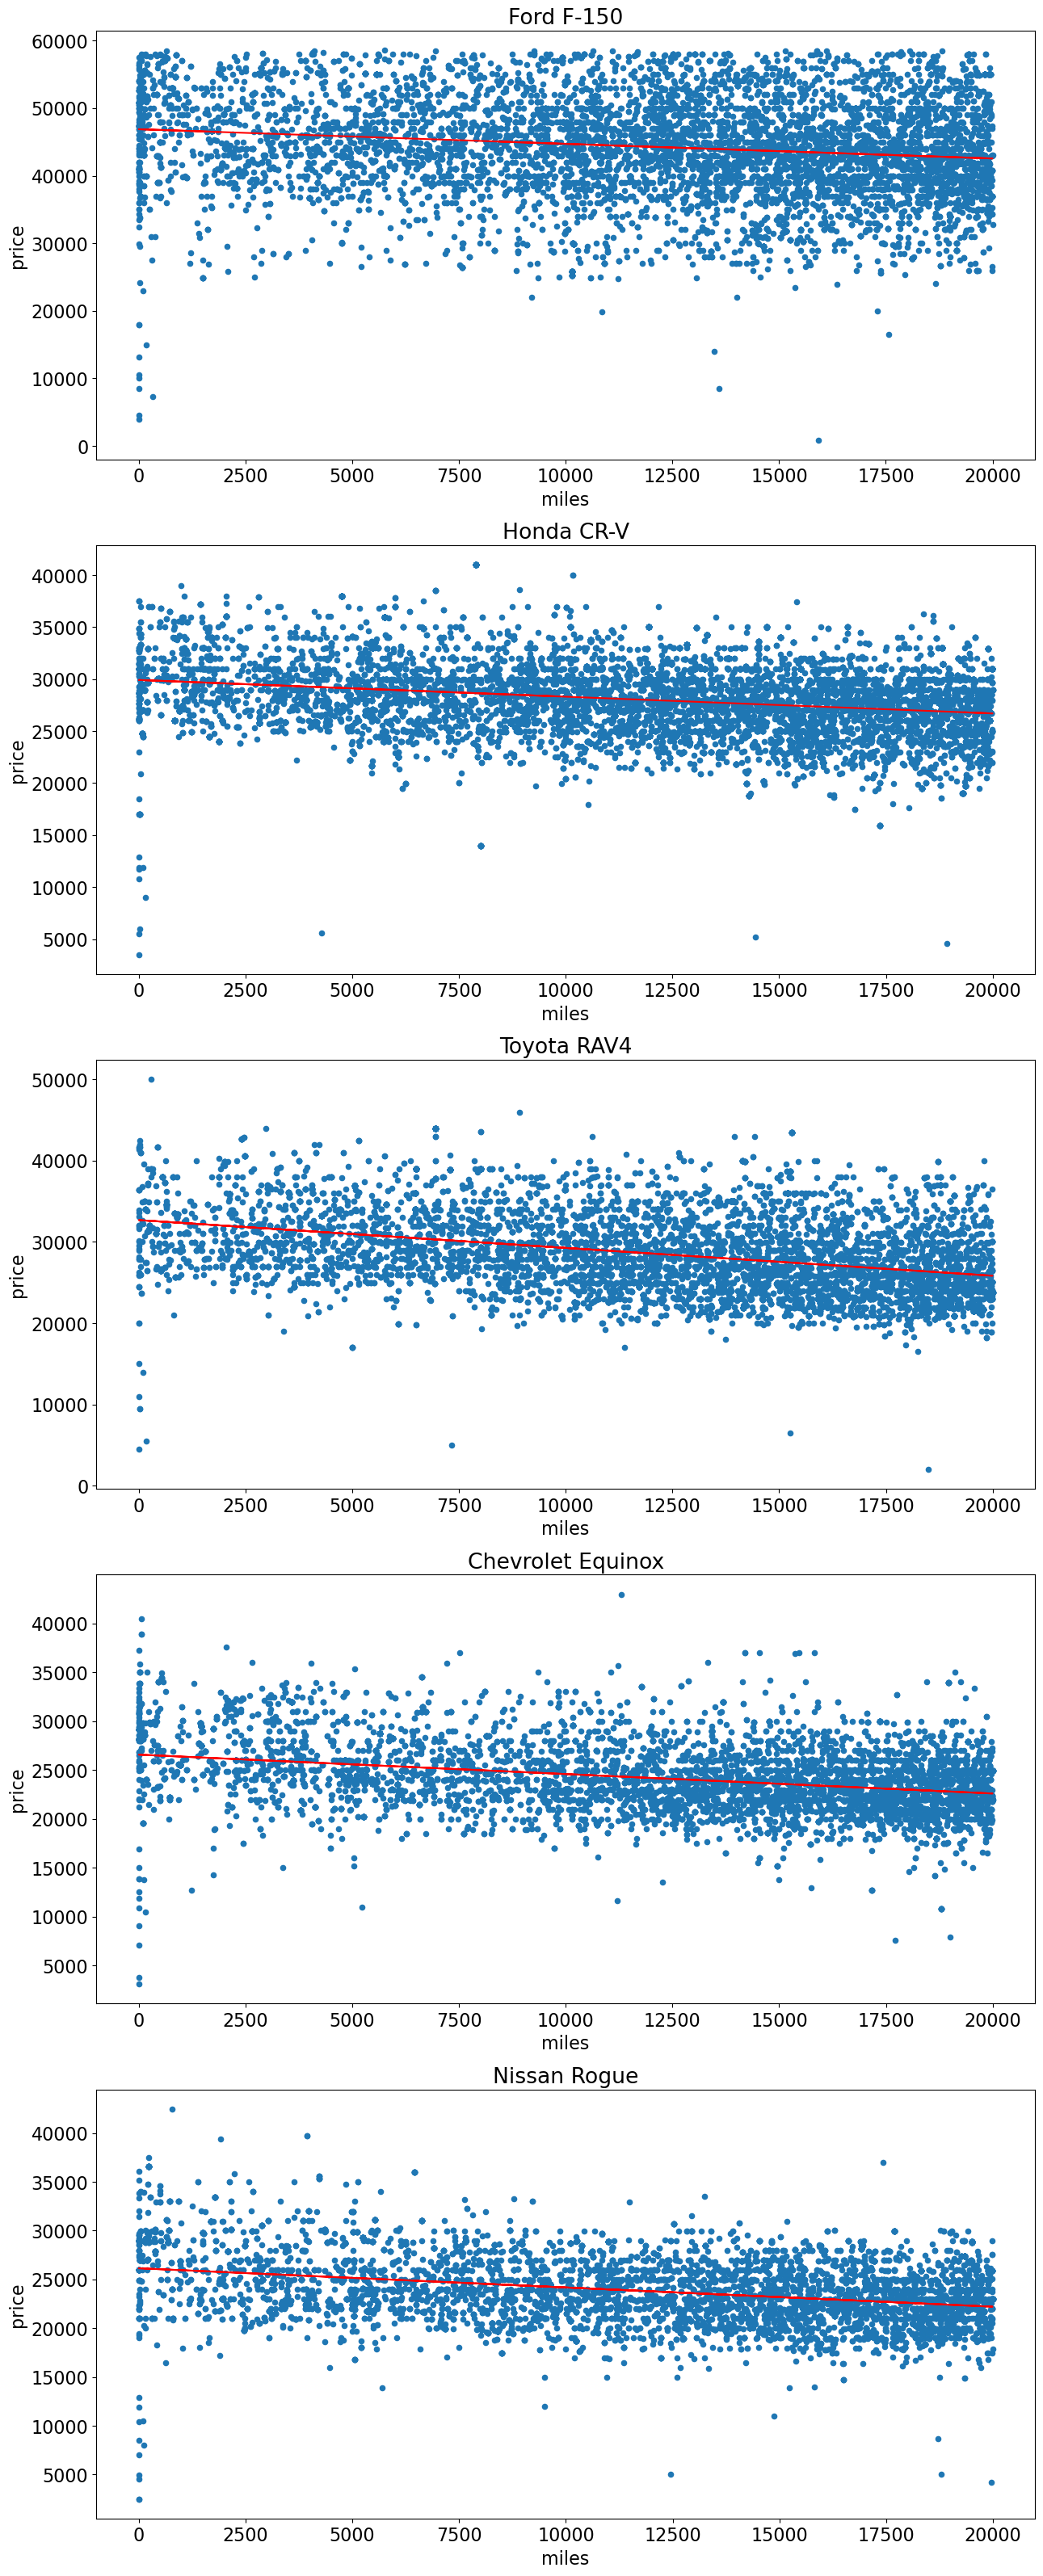

In [79]:
fig, axs = plt.subplots(nrows=5, figsize=(15,40))

for i in range(5):
    sub_df = df.select(df.price, df.miles, ) \
                .filter((df.model == top_most_popular_models_df.iloc[i]['model']) & (df.miles < 20000)) \
                .toPandas()
    _ = sub_df.plot.scatter(x='miles', y='price', ax=axs[i])
    a, b = np.polyfit(sub_df['miles'], sub_df['price'], 1)
    _ = axs[i].plot(sub_df['miles'], a*sub_df['miles']+b, color='Red')
    _ = axs[i].set_title(top_most_popular_models_df.iloc[i]['make'] + ' ' + top_most_popular_models_df.iloc[i]['model'])

    

Выведем ценовую статистику для каждой марки автомобиля 

In [85]:
makes_prices_statistic_df = []

for make in all_makes:
    stat_dict = {'make': make}
    make_prices_df = df.select(df.price).filter(df.make==make)
    stats = make_prices_df.select(
        percentile_approx(df.price,[0.25,0.5,0.75,0.95], 1000000).alias("percentiles"),
        min('price').alias('min'),
        max('price').alias('max'),
        mean('price').alias('mean'),
        stddev('price').alias('stddev'),
    ).collect()[0]
    
    stat_dict['25th percentile'] = stats['percentiles'][0] 
    stat_dict['50th percentile'] = stats['percentiles'][1]
    stat_dict['75th percentile'] = stats['percentiles'][2]
    stat_dict['95th percentile'] = stats['percentiles'][3]
    
    stat_dict['min'] = stats['min']
    stat_dict['max'] = stats['max']
    stat_dict['mean'] = stats['mean']
    stat_dict['stddev'] = stats['stddev']
    
    makes_prices_statistic_df.append(stat_dict)
    
makes_prices_statistic_df = pd.DataFrame(makes_prices_statistic_df)
makes_prices_statistic_df

,make,25th percentile,50th percentile,75th percentile,95th percentile,min,max,mean,stddev
0,Volkswagen,14496,18497,23400,32749,1650,54995,19248.150371,7313.739275
1,Lexus,25311,31580,37940,46500,2500,58595,31312.591083,9615.467906
2,Jaguar,29977,36900,44091,52416,2700,58580,36427.144670,10641.693499
3,Saturn,4990,6509,8940,17921,1495,35000,7948.838596,4687.657018
4,Maserati,36500,45988,50599,55988,5995,58554,43288.034652,9723.024171
5,FIAT,8858,12138,16999,25991,2195,36945,13566.994118,6098.826668
6,Scion,7995,10995,14887,19965,2000,30998,11655.180992,4502.471993
7,Jeep,18994,23750,31389,45499,1090,58599,25710.142628,9886.093851
8,Mitsubishi,12500,16400,19500,23900,2500,46998,16070.275028,5158.239636
9,Kia,13445,17000,20777,27695,1799,57987,17544.503896,6291.228402


Теперь составим гистограммы (для статистики квантилей) и линейные диаграммы (для мин/макс/среднее/стандартное отклонение) для более наглядного представления.

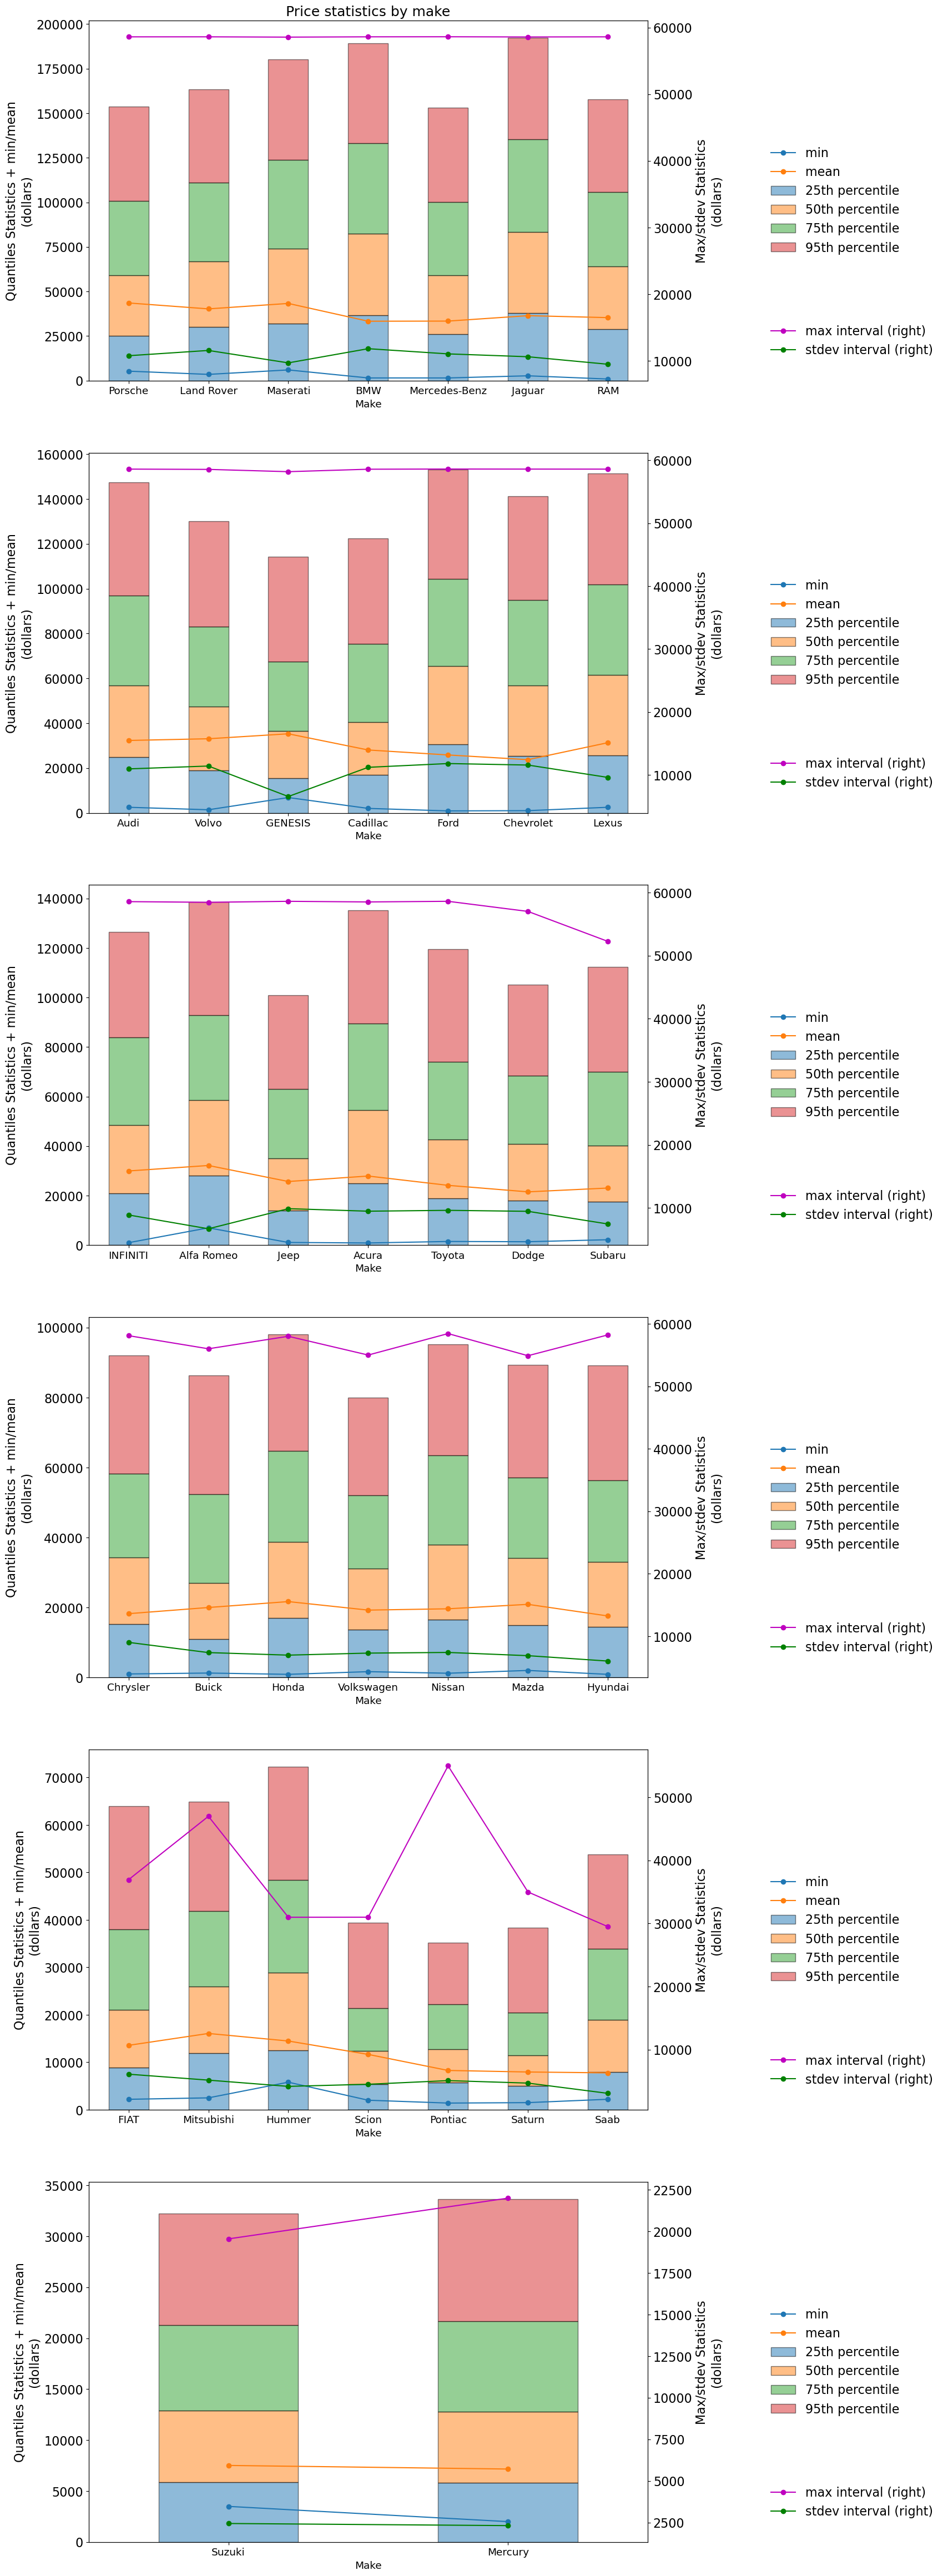

In [89]:
bar_columns = ['25th percentile', '50th percentile'
               , '75th percentile', '95th percentile']
line_columns1 = ['min', 'mean'] 
line_columns2 = ['max', 'stddev'] 
makes_prices_statistic_df = makes_prices_statistic_df.sort_values(
    by='95th percentile', ascending=False
)
figsize=(13, 59)
nrows = math.ceil(len(all_makes)/7)
fig, axs = plt.subplots(nrows=nrows, figsize=figsize)

d = axs[0].set_title('Price statistics by make', fontsize=18)
for i in range (nrows):
    makes_prices_statistic_sub_df = makes_prices_statistic_df.iloc[i*8:i*8+7,]
    plot1 = makes_prices_statistic_sub_df[['make'] + bar_columns] \
        .groupby(['make']).agg(np.mean).plot(
        kind='bar', stacked=True, grid=False, alpha=0.5, edgecolor='black', ax=axs[i], 
    )
    plot2 = makes_prices_statistic_sub_df[['make'] + line_columns1].plot(x='make', ax=axs[i], marker='o')
    ax2 = axs[i].twinx()
    plot3 = makes_prices_statistic_sub_df[['make'] + line_columns2].plot( x='make', ax=ax2, marker='o', color=['m', 'g'])
    a = axs[i].legend(loc='center left', fontsize=16, bbox_to_anchor=(1.2, 0.5), frameon=False)
    a = ax2.legend(  labels=['max interval (right)', 'stdev interval (right)']
                   , loc="center left", fontsize=16, bbox_to_anchor=(1.2, 0.11), frameon=False)
    b = axs[i].set_xticklabels(makes_prices_statistic_sub_df['make'],rotation = 'horizontal', fontsize='small')
    c = axs[i].set_xlabel('Make', fontsize='small');
    d = axs[i].set_ylabel('Quantiles Statistics + min/mean\n(dollars)', fontsize=16);
    e = ax2.set_ylabel('Max/stdev Statistics\n(dollars)', fontsize=16)
    ax2.tick_params(axis='y', labelsize=16)
    b = plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

plt.subplots_adjust(hspace=0.2)
plt.show();


Исследуем распеделение машин по типу кузова

<AxesSubplot: ylabel='percentage'>

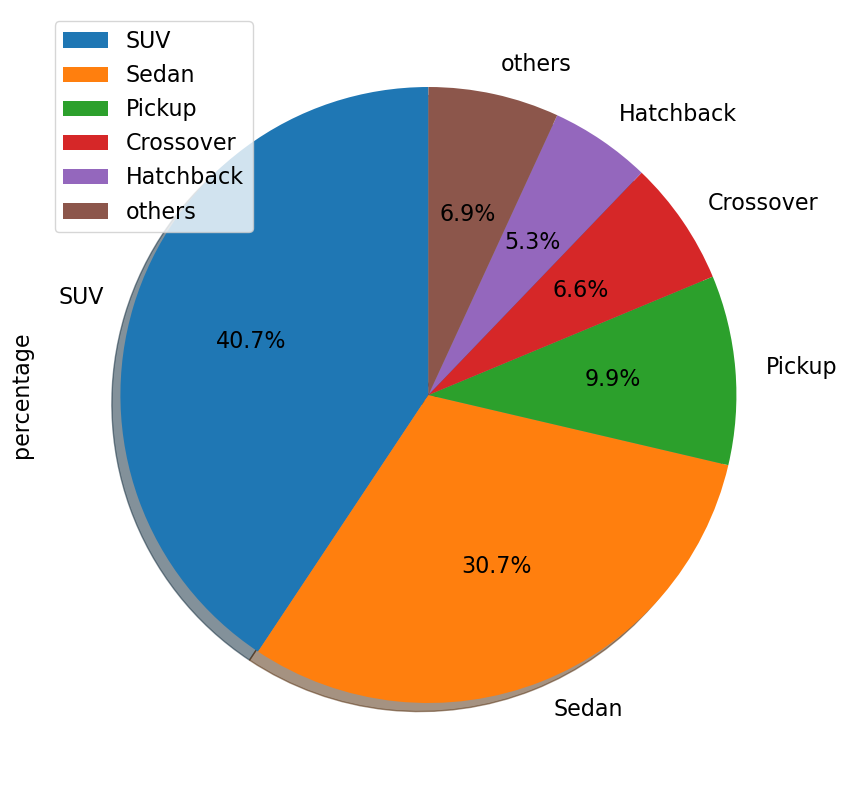

In [96]:
highest_body_types_df = df.select(df.body_type, df.id) \
    .groupBy(df.body_type) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(5) \
    .toPandas()

highest_body_types_df['percentage'] = highest_body_types_df['count'] \
    / total_cars_count * 100

others = {
    'body_type': 'others', 
    'count': total_cars_count - np.sum(highest_body_types_df['count']), 
    'percentage': 100 - np.sum(highest_body_types_df['percentage'])
}

highest_body_types_df = pd.concat([highest_body_types_df,pd.DataFrame.from_dict([others])])

#highest_body_types_df

_ = highest_body_types_df.plot.pie(
    y='percentage',
    labels=highest_body_types_df['body_type'], 
    autopct='%1.1f%%', 
    shadow=True, 
    startangle=90, 
    radius=1,
    figsize=(10, 10)
)


Самая популярная марка Ford. Исследуем эту марку. Список всех моделей:

In [107]:
ford_cars_df = df.select(df.model, df.id).filter(df.make=='Ford') \
    .groupBy(df.model) \
    .count() \
    .orderBy('count', ascending=False)

ford_cars_df.toPandas()

,model,count
0,F-150,67832
1,Escape,49967
2,Explorer,28621
3,Edge,22971
4,Fusion,22960
5,Mustang,16456
6,Focus,16144
7,Ranger,6618
8,Ecosport,6195
9,Fiesta,6184


Обратим внимание, что в названиях моделей частои используют одни и те же символы

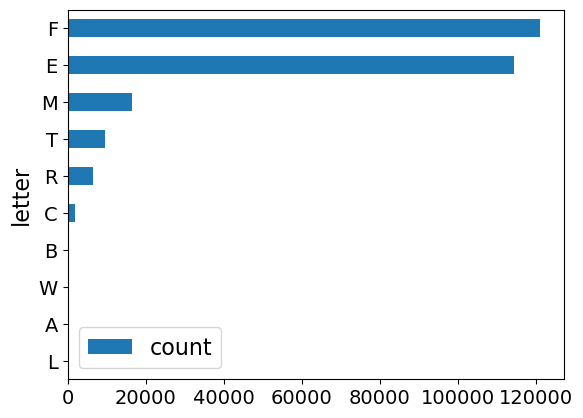

In [127]:
ford_models_letters_df = ford_cars_df.select(substring('model', 1,1).alias('letter'), 'count') \
                                    .groupBy('letter') \
                                    .sum('count') \
                                    .toPandas()

ford_models_letters_df.rename(columns = {'sum(count)': 'count'}, inplace=True)
ford_models_letters_df = ford_models_letters_df.sort_values(by='count', ascending=True).reset_index(drop=True)

_ = ford_models_letters_df.plot.barh(
    y='count',
    x='letter', 
    fontsize=14
)

Заметим, что большую часть моделей марки составляют две подгруппы - модели, чьё название начинающиеся с букв F и E. Исследуем количество моделей и ценовые характеристики каждой подгруппы

In [135]:
F_models = df.select(df.model) \
    .filter((df.make=='Ford') & (df.model.like('F%'))) \
    .distinct() \
    .rdd.flatMap(lambda x: x).collect()

df.select(df.model, df.price).filter(df.model.isin(F_models)) \
    .groupBy(df.model).agg(count("model").alias("count"), \
         avg("price").alias("avg_price"), \
         min("price").alias("min_price"), \
         max("price").alias("max_price") \
     ) \
    .orderBy('count', ascending=False) \
    .toPandas()

,model,count,avg_price,min_price,max_price
0,F-150,67832,37016.016777,888,58610
1,Fusion,22960,16366.522648,888,39999
2,Focus,16144,11767.141353,1500,44999
3,Fiesta,6184,11651.038972,1995,28982
4,Fusion Hybrid,3622,18980.082275,7500,33996
5,Flex,2400,22789.291250,3900,43910
6,Fusion Energi,1190,19993.367227,6995,40180
7,F-250 Super Duty,308,14749.094156,2495,26995
8,Five Hundred,119,5893.957983,1999,9995
9,Freestyle,72,5823.611111,1050,10000


In [134]:
E_models = df.select(df.model) \
    .filter((df.make=='Ford') & (df.model.like('E%'))) \
    .distinct() \
    .rdd.flatMap(lambda x: x).collect()

df.select(df.model, df.price).filter(df.model.isin(E_models)) \
    .groupBy(df.model).agg(count("model").alias("count"), \
         avg("price").alias("avg_price"), \
         min("price").alias("min_price"), \
         max("price").alias("max_price") \
    ) \
    .orderBy('count', ascending=False) \
    .toPandas()

,model,count,avg_price,min_price,max_price
0,Escape,49967,19000.382152,1800,40990
1,Explorer,28621,30965.087523,1200,58406
2,Edge,22971,24695.257977,2000,52385
3,Ecosport,6195,19149.916546,5700,32785
4,Expedition,5245,34019.399047,2995,58598
5,E-Series Econoline Van,503,15859.447316,3000,39988
6,Explorer Sport Trac,316,11930.167722,3750,32950
7,E-Series Econoline Wagon,243,16780.333333,5900,35155
8,Econoline Van,148,11280.945946,1999,39999
9,E-Series Cutaway,81,25409.950617,8800,40000


Самая популярная модель Ford - F-150. Посмотрим, как менялась цена на эту модель за последние десять лет

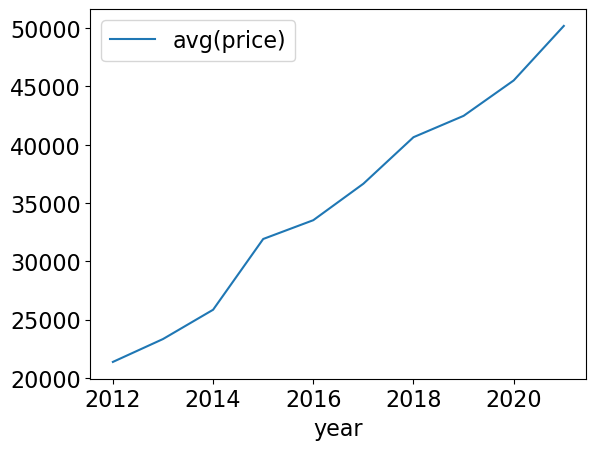

In [137]:
_ = df.select( df.price, df.year) \
    .filter((df.model == 'F-150') & (df.year >= 2012)) \
    .groupBy(df.year) \
    .avg('price') \
    .toPandas() \
    .sort_values(by='year', ascending=False) \
    .plot(x='year', y='avg(price)')